In [159]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import math
import pickle
import os
import time
from lime import lime_tabular
from mne.datasets.sleep_physionet.age import fetch_data
from scipy.integrate import simps
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,balanced_accuracy_score,f1_score,precision_score,recall_score,roc_auc_score, make_scorer
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression as LR

In [4]:
def closest(lst, K):
     return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

The Sleep Physionet dataset is annotated using 8 labels: Wake (W), Stage 1, Stage 2, Stage 3, Stage 4 corresponding to the range from light sleep to deep sleep, REM sleep (R) where REM is the abbreviation for Rapid Eye Movement sleep, movement (M), and Stage (?) for any none scored segment.

In [25]:
events_id

{'Movement time': 1,
 'Sleep stage 1': 2,
 'Sleep stage 2': 3,
 'Sleep stage 3': 4,
 'Sleep stage 4': 5,
 'Sleep stage ?': 6,
 'Sleep stage R': 7,
 'Sleep stage W': 8}

In [ ]:
subjects = np.array([1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
                     31,32,33,34,35,37,38,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,57,58,59,
                     60,61,62,63,64,65,66,67,70,71,72,73,74,75,76,77,80,81,82])
recordings = np.array([1,2]) # recordings
l_freq = 1 # low frequency threshold
h_freq = 45 # high frequency threshold
lenght = 30 # lenght of each epoch in seconds
df = pd.DataFrame()
line = 0
bands = [('delta',1,4),('theta',4,8),('alpha',8,12),('beta',12,30),('gamma',30,45)]
for subject in subjects:
    for recording in recordings:
        n = 0
        file = fetch_data([subject],recording=[recording])
        raw = file[0][0]
        annotations = file[0][1]
        raw = mne.io.read_raw_edf(raw, stim_channel='Event marker',misc=['Temp rectal'],preload=True)
        annot_train = mne.read_annotations(annotations)
        raw.set_annotations(annot_train, emit_warning=False)
        raw.drop_channels(['Resp oro-nasal','EMG submental','Temp rectal','Event marker'])
        events, events_id = mne.events_from_annotations(raw)
        #raw.notch_filter(50)
        raw.filter(l_freq,h_freq)
        ch_names = raw.info['ch_names']
        ch_names2 = list()
        for ch in ch_names:
            if 'EOG' not in ch:
                ch_names2.append(ch)
        ch_names = ch_names2
        columns = list()
        for n_i,i in enumerate(ch_names):
            for n_b,b in enumerate(bands):
                columns.append([str(i+'_'+b[0]),n_i,i,b[0],b[1],b[2]])
        srate = raw.info['sfreq']
        events = events[1:-1]
        events_list = list()
        for n,i in enumerate(events[0:-1]):
            events_list.append([i[2],i[0],events[n+1][0]])
        epochs = list()
        for el in events_list:
            start = el[1]
            stop = el[1]+lenght*srate
            while stop < el[2]:
                start += lenght*srate
                stop += lenght*srate
                epochs.append([el[0],start,stop])
        for n_e,e in enumerate(epochs):
            
            signal = raw.copy().crop(tmin=e[1]/srate,tmax=e[2]/srate).get_data()
            
            for column in columns:
                f = scipy.signal.welch(signal[column[1]],fs=srate)[0]
                freq_res = f[1] - f[0]
                s = list(scipy.signal.welch(signal[column[1]],fs=srate)[1])
                total_power = simps(s, dx=freq_res)
                band_power = simps(s[list(f).index(closest(f,[column[4]])):list(f).index(closest(f,[column[5]]))], dx=freq_res)
                band_power = band_power / total_power
                df.at[line,column[0]] = band_power
            df.at[line,'subject'] = subject
            df.at[line,'recording'] = recording
            df.at[line,'epoch'] = n_e
            df.at[line,'label'] = e[0]
            line+=1
            n+=1
df['label'] = df['label'].astype(int)
df['epoch'] = df['epoch'].astype(int)
df['recording'] = df['recording'].astype(int)
df['subject'] = df['subject'].astype(int)

In [ ]:
df = pd.read_csv('df_sleep_complete.csv')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153953 entries, 0 to 153952
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        153953 non-null  int64  
 1   EEG Fpz-Cz_delta  153953 non-null  float64
 2   EEG Fpz-Cz_theta  153953 non-null  float64
 3   EEG Fpz-Cz_alpha  153953 non-null  float64
 4   EEG Fpz-Cz_beta   153953 non-null  float64
 5   EEG Fpz-Cz_gamma  153953 non-null  float64
 6   EEG Pz-Oz_delta   153953 non-null  float64
 7   EEG Pz-Oz_theta   153953 non-null  float64
 8   EEG Pz-Oz_alpha   153953 non-null  float64
 9   EEG Pz-Oz_beta    153953 non-null  float64
 10  EEG Pz-Oz_gamma   153953 non-null  float64
 11  subject           153953 non-null  int64  
 12  recording         153953 non-null  int64  
 13  epoch             153953 non-null  int64  
 14  label             153953 non-null  int64  
dtypes: float64(10), int64(5)
memory usage: 17.6 MB


In [38]:
np.unique(df.label)

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [42]:
df = df.loc[(df.label != 6) & (df.label != 1) & (df.label != 8)]

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106902 entries, 11 to 153948
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        106902 non-null  int64  
 1   EEG Fpz-Cz_delta  106902 non-null  float64
 2   EEG Fpz-Cz_theta  106902 non-null  float64
 3   EEG Fpz-Cz_alpha  106902 non-null  float64
 4   EEG Fpz-Cz_beta   106902 non-null  float64
 5   EEG Fpz-Cz_gamma  106902 non-null  float64
 6   EEG Pz-Oz_delta   106902 non-null  float64
 7   EEG Pz-Oz_theta   106902 non-null  float64
 8   EEG Pz-Oz_alpha   106902 non-null  float64
 9   EEG Pz-Oz_beta    106902 non-null  float64
 10  EEG Pz-Oz_gamma   106902 non-null  float64
 11  subject           106902 non-null  int64  
 12  recording         106902 non-null  int64  
 13  epoch             106902 non-null  int64  
 14  label             106902 non-null  int64  
dtypes: float64(10), int64(5)
memory usage: 13.0 MB


In [44]:
np.unique(df.label)

array([2, 3, 4, 5, 7], dtype=int64)

In [21]:
for n,c in enumerate(df.columns):
    print(n,c)

0 Unnamed: 0
1 EEG Fpz-Cz_delta
2 EEG Fpz-Cz_theta
3 EEG Fpz-Cz_alpha
4 EEG Fpz-Cz_beta
5 EEG Fpz-Cz_gamma
6 EEG Pz-Oz_delta
7 EEG Pz-Oz_theta
8 EEG Pz-Oz_alpha
9 EEG Pz-Oz_beta
10 EEG Pz-Oz_gamma
11 subject
12 recording
13 epoch
14 label


In [12]:
df.columns[1:11] # columns used as feature for classification

Index(['EEG Fpz-Cz_delta', 'EEG Fpz-Cz_theta', 'EEG Fpz-Cz_alpha',
       'EEG Fpz-Cz_beta', 'EEG Fpz-Cz_gamma', 'EEG Pz-Oz_delta',
       'EEG Pz-Oz_theta', 'EEG Pz-Oz_alpha', 'EEG Pz-Oz_beta',
       'EEG Pz-Oz_gamma'],
      dtype='object')

In [13]:
df.columns[-1]

'label'

In [187]:
events_interest = ['Sleep stage 1','Sleep stage 2','Sleep stage 3','Sleep stage 4','Sleep stage REM']

In [188]:
dict_prob = dict()
for n in np.unique(df['label']):
    dict_prob[n]=(df['label'] == n).sum()/len(df['label'] == n)

for e_i,prob in zip(events_interest,dict_prob.values()):
    print(e_i,prob)
    
print('casual probability unweighted: ',1/len(np.unique(df['label'])))

Sleep stage 1 0.4325644047819498
Sleep stage 2 0.20747974780640213
Sleep stage 3 0.053450824119286824
Sleep stage 4 0.12298179641166676
Sleep stage REM 0.18352322688069447
casual probability unweighted:  0.2


In [229]:
df.describe()

,EEG Fpz-Cz_delta,EEG Fpz-Cz_theta,EEG Fpz-Cz_alpha,EEG Fpz-Cz_beta,EEG Fpz-Cz_gamma,EEG Pz-Oz_delta,EEG Pz-Oz_theta,EEG Pz-Oz_alpha,EEG Pz-Oz_beta,EEG Pz-Oz_gamma,subject,recording,epoch,label
count,153953.000000,153953.000000,153953.000000,153953.000000,153953.000000,153953.000000,153953.000000,153953.000000,153953.000000,153953.000000,153953.000000,153953.000000,153953.000000,153953.000000
mean,0.374128,0.103386,0.055846,0.079745,0.034388,0.303840,0.141022,0.098756,0.098078,0.049457,43.387456,1.492585,598.556741,4.053036
std,0.108131,0.048180,0.051114,0.070953,0.055897,0.119179,0.068477,0.100686,0.084010,0.084895,23.671695,0.499947,441.313739,2.155668
min,0.030537,0.004176,0.001610,0.001116,0.000071,0.019033,0.003187,0.001397,0.001267,0.000091,1.000000,1.000000,0.000000,1.000000
25%,0.310541,0.068807,0.024846,0.029701,0.005128,0.218722,0.087111,0.046142,0.037184,0.005056,23.000000,1.000000,260.000000,2.000000
50%,0.383545,0.095706,0.041549,0.057016,0.013369,0.323972,0.134534,0.070017,0.067498,0.010927,45.000000,1.000000,521.000000,3.000000
75%,0.449161,0.129010,0.067358,0.105639,0.036199,0.391334,0.184558,0.106503,0.133458,0.038208,65.000000,2.000000,814.000000,6.000000
max,0.817445,0.674181,0.559923,0.529833,0.645127,0.878269,0.645904,0.787351,0.527710,0.562545,82.000000,2.000000,2500.000000,8.000000


In [45]:
#mlp = MLP(hidden_layer_sizes=(10,20,30,20,10,8),solver='adam',activation='relu',max_iter=2000,shuffle=True,momentum=0.9,learning_rate='invscaling')
mlp = MLP(hidden_layer_sizes=(32,64,64,32),solver='adam',activation='relu',max_iter=2000,shuffle=True,momentum=0.8,learning_rate='adaptive',early_stopping=True,n_iter_no_change=30)

X, y = df[df.columns[1:11]],np.array(df[df.columns[-1]])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

mlp.fit(np.array(X_train),y_train)
y_pred = mlp.predict(X_test)
predict_proba = mlp.predict_proba(X_test)

C:\Users\A2VILab\anaconda3\envs\eeg\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
C:\Users\A2VILab\anaconda3\envs\eeg\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [46]:
print('accuracy: ',accuracy_score(y_test,y_pred))
print('balanced_accuracy_score: ',balanced_accuracy_score(y_test,y_pred))
print('f1_score: ',f1_score(y_test,y_pred,average='weighted'))
print('recall_score: ',recall_score(y_test,y_pred,average='weighted'))
print('roc_auc_score: ',roc_auc_score(y_test,predict_proba,multi_class='ovr'))
print('roc_auc_score: ',roc_auc_score(y_test,predict_proba,multi_class='ovo'))

accuracy:  0.6637564487782754
balanced_accuracy_score:  0.5768482001036856
f1_score:  0.6444572023976826
recall_score:  0.6637564487782754
roc_auc_score:  0.8927646497690314
roc_auc_score:  0.892060031006489


In [176]:
list(events_id.values())

['Movement time',
 'Sleep stage 1',
 'Sleep stage 2',
 'Sleep stage 3',
 'Sleep stage 4',
 'Sleep stage ?',
 'Sleep stage R',
 'Sleep stage W']

In [146]:
conf_matrix=confusion_matrix(y_test,y_pred,normalize='pred')#,labels=['Stage 1','Stage 2','Stage 3','Stage 4','Stage REM'])

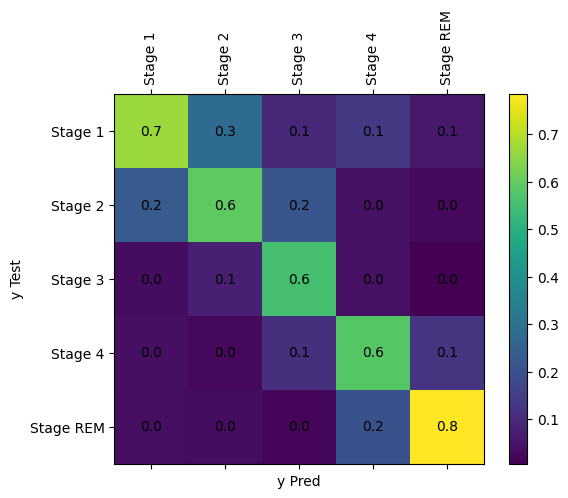

In [147]:
text = ['Stage 1','Stage 2','Stage 3','Stage 4','Stage REM']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix)
fig.colorbar(cax)
xaxis = np.arange(len(text))
ax.set_ylabel('y Test')
ax.set_xlabel('y Pred')
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(text, rotation=90)
ax.set_yticklabels(text)
for (i, j), z in np.ndenumerate(conf_matrix):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

plt.show()

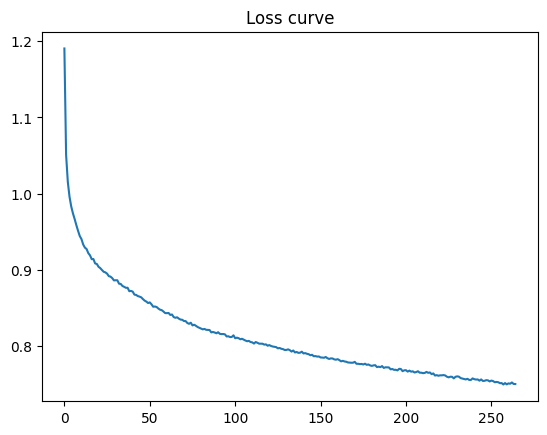

In [51]:
plt.plot(mlp.loss_curve_)
plt.title('Loss curve');

In [176]:
grid = [
    {'estimator': [MLP(random_state=42)],
     'estimator__solver': ['adam','sgd'],
     'estimator__learning_rate_init': [0.0001],
     'estimator__max_iter': [300],
     'estimator__hidden_layer_sizes': [(32,64,64,32),(10,20,20,10),(8,16,32,64,8)],
     'estimator__activation': ['logistic', 'relu'],
     'estimator__alpha': [0.001, 0.005,0.0001],
     'estimator__early_stopping': [False,True]
     }
]

pipe = Pipeline([('scaler', None), ('estimator', MLP())])
grid_search = GridSearchCV(estimator=pipe, param_grid=grid, 
                            scoring=make_scorer(accuracy_score),# average='macro'), 
                            n_jobs=-1, cv=2, refit=True, verbose=1, 
                            return_train_score=False)

grid_search.fit(X, y)

Fitting 2 folds for each of 72 candidates, totalling 144 fits


C:\Users\A2VILab\anaconda3\envs\eeg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('scaler', None),
                                       ('estimator', MLPClassifier())]),
             n_jobs=-1,
             param_grid=[{'estimator': [MLPClassifier(alpha=0.005,
                                                      hidden_layer_sizes=(8, 16,
                                                                          32,
                                                                          64,
                                                                          8),
                                                      learning_rate_init=0.0001,
                                                      max_iter=300,
                                                      random_state=42,
                                                      solver='sgd')],
                          'estimator__activation': ['logistic', 'relu'],
                          'estimator__alpha': [0.001, 0.005, 0.0001],
                          'estimator__early_stopping': [False, True],
                          'estimator__hidden_layer_sizes': [(32, 64, 64, 32),
                                                            (10, 20, 20, 10),
                                                            (8, 16, 32, 64, 8)],
                          'estimator__learning_rate_init': [0.0001],
                          'estimator__max_iter': [300],
                          'estimator__solver': ['adam', 'sgd']}],
             scoring=make_scorer(accuracy_score), verbose=1)

In [177]:
grid_search.best_params_

{'estimator': MLPClassifier(alpha=0.005, hidden_layer_sizes=(8, 16, 32, 64, 8),
               learning_rate_init=0.0001, max_iter=300, random_state=42,
               solver='sgd'),
 'estimator__activation': 'relu',
 'estimator__alpha': 0.005,
 'estimator__early_stopping': False,
 'estimator__hidden_layer_sizes': (8, 16, 32, 64, 8),
 'estimator__learning_rate_init': 0.0001,
 'estimator__max_iter': 300,
 'estimator__solver': 'sgd'}

In [178]:
grid_search.best_score_

0.5463602177695459

In [192]:
mlp_best = MLP(hidden_layer_sizes=(32,64,64,32),solver='adam',activation='relu',max_iter=1000,shuffle=True,momentum=0.8,learning_rate_init=0.0001,learning_rate='adaptive',early_stopping=True,n_iter_no_change=30, alpha=0.005)

X, y = df[df.columns[1:11]],np.array(df[df.columns[-1]])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

mlp_best.fit(np.array(X_train),y_train)
y_pred = mlp_best.predict(X_test)
predict_proba = mlp_best.predict_proba(X_test)

C:\Users\A2VILab\anaconda3\envs\eeg\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
C:\Users\A2VILab\anaconda3\envs\eeg\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


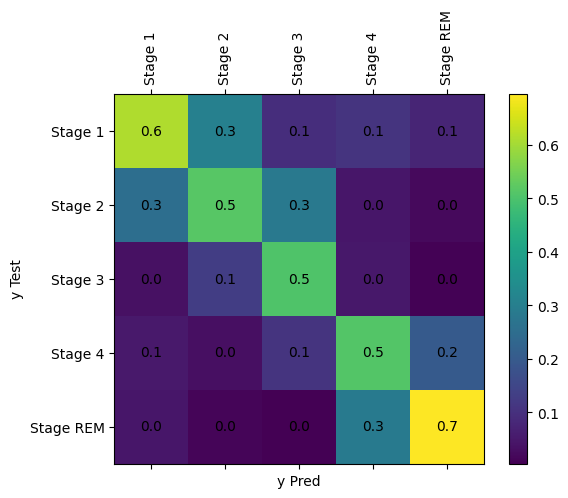

In [193]:
conf_matrix=confusion_matrix(y_test,y_pred,normalize='pred')#,labels=['Stage 1','Stage 2','Stage 3','Stage 4','Stage REM'])
text = ['Stage 1','Stage 2','Stage 3','Stage 4','Stage REM']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix)
fig.colorbar(cax)
xaxis = np.arange(len(text))
ax.set_ylabel('y Test')
ax.set_xlabel('y Pred')
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(text, rotation=90)
ax.set_yticklabels(text)
for (i, j), z in np.ndenumerate(conf_matrix):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

plt.show()

In [194]:
print('accuracy: ',accuracy_score(y_test,y_pred))
print('balanced_accuracy_score: ',balanced_accuracy_score(y_test,y_pred))
print('f1_score: ',f1_score(y_test,y_pred,average='weighted'))
print('recall_score: ',recall_score(y_test,y_pred,average='weighted'))
print('roc_auc_score: ',roc_auc_score(y_test,predict_proba,multi_class='ovr'))
print('roc_auc_score: ',roc_auc_score(y_test,predict_proba,multi_class='ovo'))

accuracy:  0.6096717500992119
balanced_accuracy_score:  0.48641432672882046
f1_score:  0.5646078554499115
recall_score:  0.6096717500992119
roc_auc_score:  0.8532177961192765
roc_auc_score:  0.8515291064672061


In [66]:
clf = svm.SVC(degree=3,kernel='poly')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5888939282272238

In [93]:
knn = KNN(n_neighbors=10,weights='distance')
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.6271047111514259

In [68]:
lda =  LDA(solver='svd', shrinkage=None, priors=None, n_components=None, store_covariance=False, tol=0.0001, covariance_estimator=None)
lda.fit(X_train,y_train)
lda.score(X_test,y_test)

0.5483304042179262

In [195]:
X, y = df[df.columns[1:11]],np.array(df[df.columns[-1]])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
lr = LR(multi_class='multinomial',max_iter=1000)
lr.fit(X_train,y_train)
lr.score(X_test,y_test)

0.5487839446680651

In [211]:
raw.drop_channels('EOG horizontal')

<RawEDF | SC4011E0-PSG.edf, 2 x 8406000 (84060.0 s), ~128.3 MB, data loaded>

In [225]:
srate = raw.info['sfreq']

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.560 (s)


C:\Users\A2VILab\AppData\Local\Temp\ipykernel_139284\1677421076.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(tmin=2154000/100,tmax=2190000/100)
C:\Users\A2VILab\anaconda3\envs\eeg\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


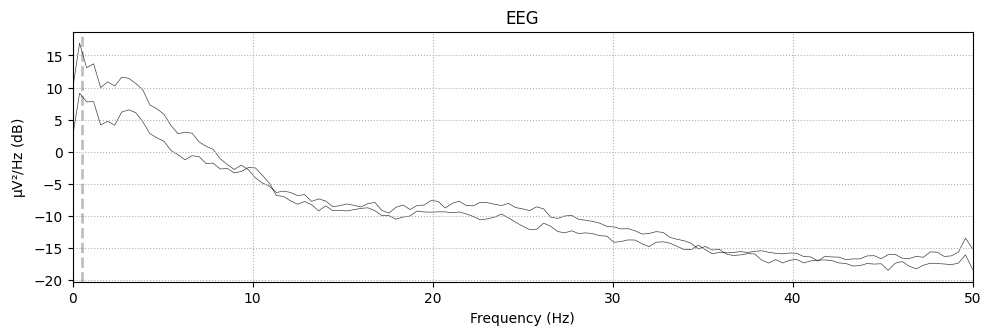

In [212]:
# stage 1
raw.plot_psd(tmin=2154000/srate,tmax=2190000/srate)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.560 (s)


C:\Users\A2VILab\AppData\Local\Temp\ipykernel_139284\1701844022.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(tmin=2190000/100,tmax=2196000/100)
C:\Users\A2VILab\anaconda3\envs\eeg\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


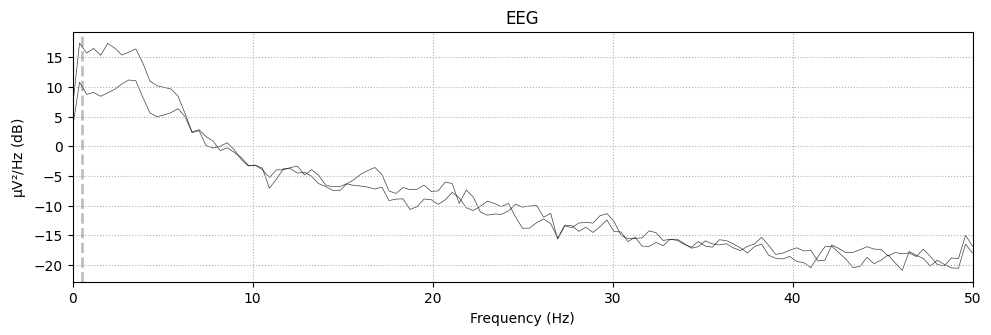

In [213]:
# stage 2
raw.plot_psd(tmin=2190000/srate,tmax=2196000/srate)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.560 (s)


C:\Users\A2VILab\AppData\Local\Temp\ipykernel_139284\852383302.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(tmin=2388000/100,tmax=2391000/100)
C:\Users\A2VILab\anaconda3\envs\eeg\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


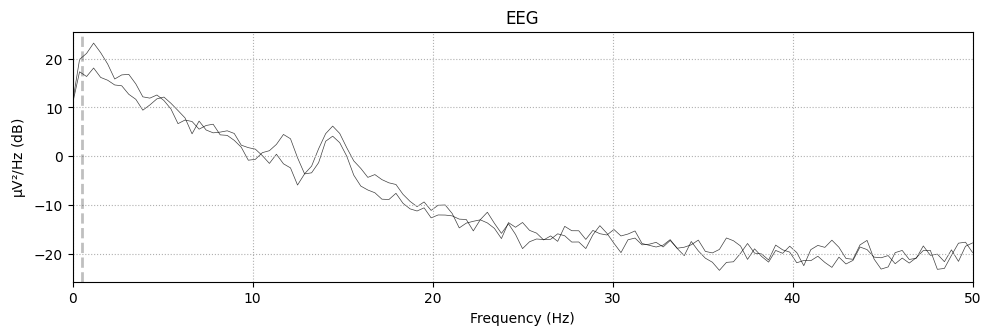

In [214]:
# stage 3
raw.plot_psd(tmin=2388000/srate,tmax=2391000/srate)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.560 (s)


C:\Users\A2VILab\AppData\Local\Temp\ipykernel_139284\3130185922.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(tmin=2511000/100,tmax=2514000/100)
C:\Users\A2VILab\anaconda3\envs\eeg\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


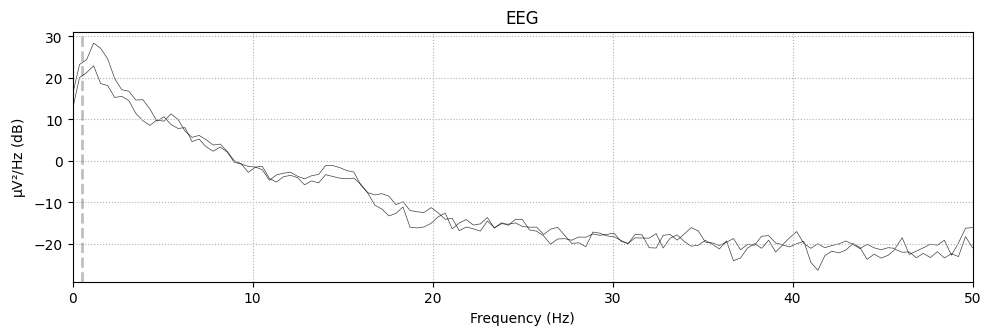

In [216]:
# stage 4
raw.plot_psd(tmin=2511000/srate,tmax=2514000/srate)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.560 (s)


C:\Users\A2VILab\AppData\Local\Temp\ipykernel_139284\3766008811.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(tmin=2271000/100,tmax=2334000/100)
C:\Users\A2VILab\anaconda3\envs\eeg\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


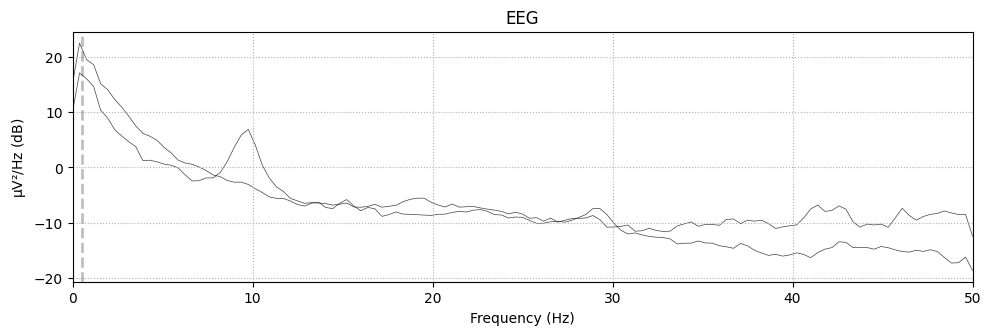

In [217]:
# stage W
raw.plot_psd(tmin=2271000/srate,tmax=2334000/srate)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.560 (s)


C:\Users\A2VILab\AppData\Local\Temp\ipykernel_139284\1952874692.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(tmin=2871000/100,tmax=3036000/100)
C:\Users\A2VILab\anaconda3\envs\eeg\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


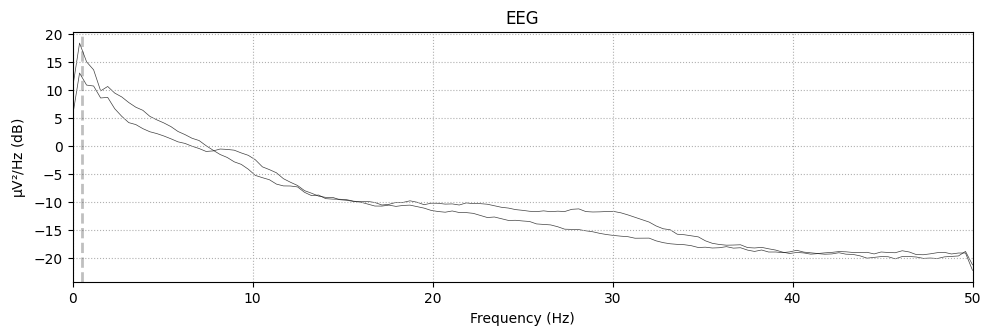

In [ ]:
# stage R
raw.plot_psd(tmin=2871000/srate,tmax=3036000/srate)

In [229]:
file = fetch_data([subject],recording=[recording])
raw = file[0][0]
annotations = file[0][1]
raw = mne.io.read_raw_edf(raw, stim_channel='Event marker',misc=['Temp rectal'],preload=True)
annot_train = mne.read_annotations(annotations)
raw.set_annotations(annot_train, emit_warning=False)
events, events_id = mne.events_from_annotations(raw)
#raw.notch_filter(50)
raw.filter(l_freq,h_freq)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from C:\Users\A2VILab\mne_data\physionet-sleep-data\SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8405999  =      0.000 ... 84059.990 secs...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage ?', 'Sleep stage R', 'Sleep stage W']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 47.50 Hz)
- Filter length: 331 samples (3.3

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished


<RawEDF | SC4011E0-PSG.edf, 7 x 8406000 (84060.0 s), ~448.9 MB, data loaded>

In [231]:
raw.plot();